To train a network on the mix of FM and Cf calls, I have to generate spectrograms of the audio snippets. The spectrograms also need to be normalised to have values between 0-1, which allows the network parameter estimation to run well. 

In [1]:
from __future__ import division
from keras.utils import to_categorical
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
import numpy as np 
import pandas as pd
import scipy.signal as signal 
import soundfile as sf

Using TensorFlow backend.


In [2]:
%matplotlib notebook

In [3]:
# load the csv file
audio_labels = pd.read_csv('audio_labels.csv')

In [4]:
# make a column to convert groupsie labels into numeric
text_to_int = {'none':0,
                       'single':1,
                       'multi':2
                      }
def convert_txt_to_int(X):
    entry = X['groupsize_label']
    return( text_to_int[entry])

audio_labels['groupsize_intlabel'] = audio_labels.apply(convert_txt_to_int, 1 )

In [5]:

audio_labels.head()

,date_recorded,file_name,time_start,time_end,duration,channel_num,groupsize_label,Ferrum_call,BlEuMi_call,Myotis_call,Unnamed: 10,groupsize_intlabel
0,2018-08-16,T0000370.WAV,45.0,45.2,0.2,1,single,0,1,0,NaN,1
1,2018-08-16,T0000370.WAV,52.0,52.2,0.2,2,single,0,1,1,NaN,1
2,2018-08-16,T0000370.WAV,54.5,54.7,0.2,2,none,0,0,0,NaN,0
3,2018-08-16,T0000370.WAV,59.6,59.8,0.2,2,single,0,1,0,NaN,1
4,2018-08-16,T0000371.WAV,9.1,9.3,0.2,2,none,0,0,0,NaN,0


In [6]:
audio_labels.tail()

,date_recorded,file_name,time_start,time_end,duration,channel_num,groupsize_label,Ferrum_call,BlEuMi_call,Myotis_call,Unnamed: 10,groupsize_intlabel
306,2018-08-19,T0000029.WAV,9.9,10.1,NaN,1,multi,1,1,0,NaN,2
307,2018-08-19,T0000035.WAV,0.9,1.1,NaN,1,single,1,0,0,NaN,1
308,2018-08-19,T0000040.WAV,51.6,51.8,NaN,0,single,0,1,1,NaN,1
309,2018-08-19,T0000057.WAV,23.2,23.4,NaN,0,multi,1,1,0,NaN,2
310,2018-08-19,T0000057.WAV,58.9,59.1,NaN,1,multi,1,1,0,NaN,2


In [7]:
audio_labels['date_recorded'].unique()

array(['2018-08-16', '2018-08-18', '2018-08-19'], dtype=object)

In [8]:
folder_paths = {'2018-08-16':'/media/tbeleyur/THEJASVI_DATA_BACKUP_3/fieldwork_2018_002/horseshoe_bat/audio/2018-08-16/',
                '2018-08-18':'/media/tbeleyur/THEJASVI_DATA_BACKUP_3/fieldwork_2018_002/horseshoe_bat/audio/2018-08-18/',
                 '2018-08-19':'/media/tbeleyur/THEJASVI_DATA_BACKUP_3/fieldwork_2018_002/horseshoe_bat/audio/2018-08-19/ch1/'
               }



In [9]:
def make_combinationname(df):
    combined = df['groupsize_label']+str(df['Ferrum_call'])+str(df['BlEuMi_call'])+str(df['Myotis_call'])
    return(combined)

In [10]:
audio_labels['combination_name'] = audio_labels.apply(make_combinationname,1)


In [11]:
def get_audio_from_dfrow(dfrow, fs = 250000):
    start_ind, end_ind = int(np.around(dfrow['time_start']*fs)), int(np.around((dfrow['time_start']+0.2)*fs))
    audio, fs = sf.read(folder_paths[dfrow['date_recorded']]+dfrow['file_name'],
                        start=start_ind, stop=end_ind+1)
    chnum  = dfrow['channel_num']
    audio_snippet = audio[:,chnum]
    return(audio_snippet, fs)
    

In [12]:
def make_normalised_spectrogram(dfrow, **kwargs):
    au, fs = get_audio_from_dfrow(dfrow)
    
    if len(kwargs.keys()) >=1:
        f,t, S = signal.spectrogram(au, fs=fs, **kwargs)
    else:
        f,t, S = signal.spectrogram(au, fs=fs, nperseg=1024, noverlap=512)
    
    S = 20*np.log10(S/np.min(S))
    # normalise so values lie between 0-1
    S *= 1/np.max(S)
    # reshape so the array has a 1 dim 'thickness'
    S = S.reshape(1,S.shape[0],S.shape[1])
    return(S)

In [13]:
def get_specgram_label(dfrow):
    im_label = np.array([dfrow['Ferrum_call'],
                              dfrow['BlEuMi_call'],
                              dfrow['Myotis_call'],
                              dfrow['groupsize_intlabel']])
    return(im_label)
                

In [14]:
def make_specgram_and_label(dfrow, **kwargs):
    S = make_normalised_spectrogram(dfrow, **kwargs)
    label = dfrow['combination_name']
    return(S, label)

In [15]:

s= make_normalised_spectrogram(audio_labels.iloc[0,:], nperseg=512, noverlap=256)
print(s.shape)


(1, 257, 194)


#### Let's split up data into training and validation now:
We'll take a 75:25 split of the available data and distribute it to the training(75%) and validation (25%) data. 


In [16]:
all_combis = audio_labels['combination_name'].unique()

In [17]:
training_labels = pd.DataFrame()
testing_labels = pd.DataFrame()

training_fraction = 0.75
testing_fraction = 0.25
for each_combi in all_combis:
    combi_rows = audio_labels['combination_name'] == each_combi
    combi_data = audio_labels[combi_rows].reset_index(drop=True)

    num_trainingrows = int(combi_data.shape[0]*training_fraction)
    training_labels = training_labels.append(combi_data[:num_trainingrows])
    testing_labels = testing_labels.append(combi_data[num_trainingrows:]).reset_index(drop=True)

In [18]:
training_labels.shape

(230, 13)

In [19]:
testing_labels.shape

(81, 13)

#### Let's generate the spectrograms and labels for all of the labelled data now:

In [20]:
# decide spectrogram FFt parameters
num_segs = 512
overlap = 256

In [21]:
training_specgrams = np.zeros((training_labels.shape[0],s.shape[1],s.shape[2]))
training_num_labels = []

In [22]:
testing_specgrams = np.zeros((testing_labels.shape[0],s.shape[1],s.shape[2]))
testing_num_labels = []

In [23]:
s.shape

(1, 257, 194)

In [24]:
for i, row in training_labels.iterrows():
    s_tr, label = make_specgram_and_label(row, nperseg=num_segs, noverlap=overlap)
    training_specgrams[i,:,:] = s_tr
    training_num_labels.append(label)

In [25]:
for i, row in testing_labels.iterrows():
    s_test, label = make_specgram_and_label(row, nperseg=num_segs, noverlap=overlap)
    testing_specgrams[i,:,:] = s_test
    testing_num_labels.append(label)

<IPython.core.display.Javascript object>


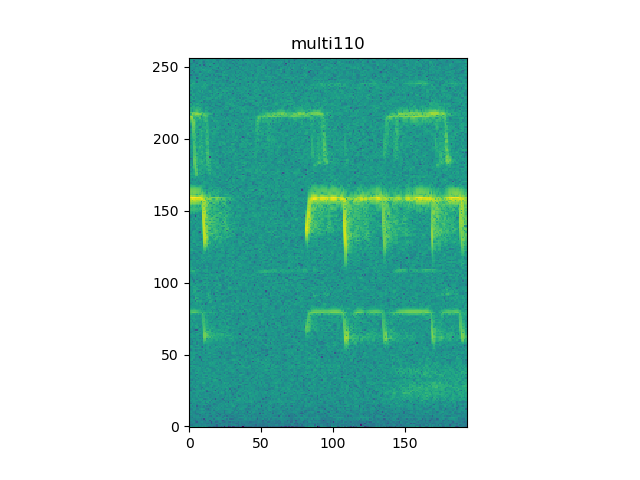

In [26]:
i = np.random.choice(np.arange(len(testing_labels)), 1 )
plt.figure()
plt.title(testing_num_labels[int(i)])
plt.imshow(testing_specgrams[i,:,:].reshape(testing_specgrams.shape[1], testing_specgrams.shape[2]), origin='lower')

In [27]:
# SAve the data as np arrays.

np.save('training_data/training_specgram_257x194.npy',training_specgrams)
np.save('training_data/testing_specgram_257x194.npy',testing_specgrams)
np.save('training_data/training_labels_257x194.npy',training_num_labels)
np.save('training_data/testing_labels_257x194.npy',testing_num_labels)
